# **(1) NYC TAXI**

### Dependency checks

In [59]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [61]:
trainfull = pd.read_csv('../data/train.csv')
testFull = pd.read_csv('../data/test.csv')

# Create trainfull_copy with uncleaned data for visualizations
trainfull_copy = trainfull.copy()
# Display info to verify the dataframe loaded correctly
print(f"trainfull_copy shape: {trainfull_copy.shape}")
print(f"\nFirst few rows:")
trainfull_copy.head()

trainfull_copy shape: (1458644, 11)

First few rows:


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Checking for missing values

In [62]:
# Check for missing values in each column
missing_counts = trainfull_copy.isnull().sum()

# Display columns that have missing values (if any)
print("Missing values per column:")
print(missing_counts[missing_counts > 0])

if trainfull_copy.isnull().values.any():
    print("\nThe dataset contains missing values.")
else:
    print("\nThe dataset has no missing values.")


Missing values per column:
Series([], dtype: int64)

The dataset has no missing values.


### Consistency check : **trip times**

In [63]:
import pandas as pd
import numpy as np

def check_duration_consistency(data, tolerance=1):    
    # Ensure datetimes are actually datetime objects
    # (pickup_datetime is already converted in your create_datetime_features, but dropoff might not be)
    pickup = pd.to_datetime(data['pickup_datetime'])
    dropoff = pd.to_datetime(data['dropoff_datetime'])
    
    # Calculate duration in seconds
    calculated_duration = (dropoff - pickup).dt.total_seconds()
    
    # Calculate the absolute difference
    diff = np.abs(data['trip_duration'] - calculated_duration)
    
    # Find inconsistencies
    inconsistent_mask = diff > tolerance
    num_inconsistent = inconsistent_mask.sum()
    
    if num_inconsistent == 0:
        print("All trip_duration values are consistent with timestamps.")
    else:
        print(f"Found {num_inconsistent} records with inconsistent durations (diff > {tolerance}s).")
        
        # Show some examples of inconsistent rows
        bad_rows = data[inconsistent_mask].copy()
        bad_rows['calculated_duration'] = calculated_duration[inconsistent_mask]
        bad_rows['diff'] = diff[inconsistent_mask]
        
        print("\nTop 5 biggest inconsistencies:")
        cols_to_show = ['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'calculated_duration', 'diff']
        print(bad_rows.sort_values('diff', ascending=False)[cols_to_show].head())

# Run the check on your trainfull_copy dataset
check_duration_consistency(trainfull_copy)

All trip_duration values are consistent with timestamps.


# **(2) Feature Visualizations**

## Plotting pickup coordinates

In [64]:
# First install: %pip install plotly
import plotly.express as px

# Sample the data (full dataset is too large to plot)
sample = trainfull_copy.sample(n=10000, random_state=42)

# Plot pickups
fig = px.scatter_mapbox(
    sample,
    lat='pickup_latitude',
    lon='pickup_longitude',
    size_max=5,
    zoom=10,
    center={'lat': 40.7128, 'lon': -74.0060},
    mapbox_style='carto-positron',
    title='NYC Taxi Pickups',
    opacity=0.5
)
fig.show()

/var/folders/fg/jt9mq0js5cqgg812yfmz3gg00000gp/T/ipykernel_25813/802383537.py:8: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



####Most pickups are coming from Manhattan, other notable pickup spots are from JFK airport 

## Date/time vs trip duration

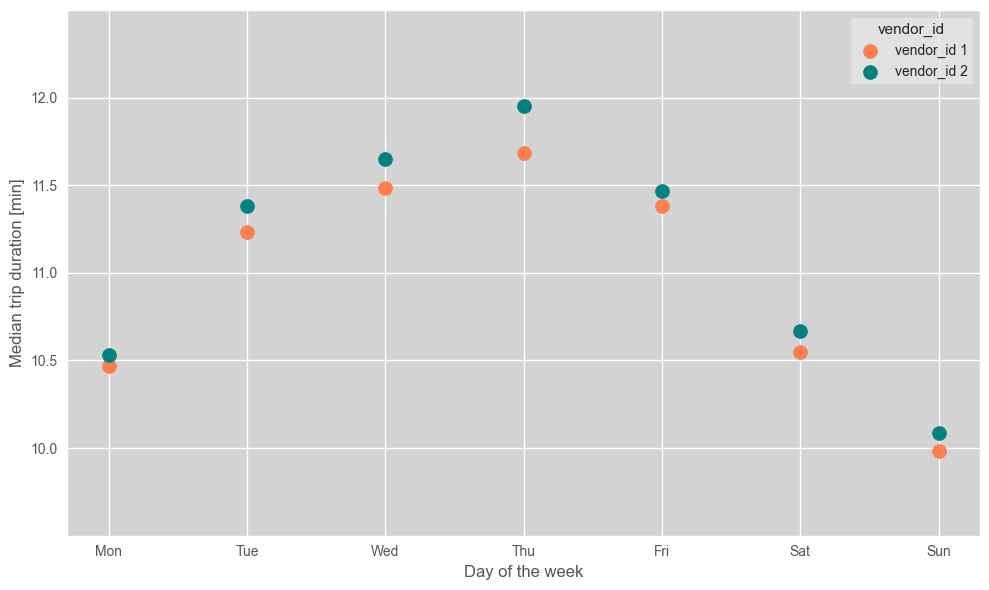

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

trainfull_copy['pickup_datetime'] = pd.to_datetime(trainfull_copy['pickup_datetime'])
trainfull_copy['pickup_dayofweek'] = trainfull_copy['pickup_datetime'].dt.dayofweek
# Convert trip_duration from seconds to minutes
trainfull_copy['trip_duration_min'] = trainfull_copy['trip_duration'] / 60

# Map day of week numbers to day names
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
trainfull_copy['day_name'] = trainfull_copy['pickup_dayofweek'].map({i: day_names[i] for i in range(7)})

# Calculate median trip duration by day of week and vendor_id
median_duration = trainfull_copy.groupby(['day_name', 'vendor_id'])['trip_duration_min'].median().reset_index()
median_duration = median_duration.sort_values(['day_name', 'vendor_id'])

# Ensure correct order of days
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
median_duration['day_name'] = pd.Categorical(median_duration['day_name'], categories=day_order, ordered=True)
median_duration = median_duration.sort_values('day_name')

# Create the visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Separate data by vendor_id
vendor_1 = median_duration[median_duration['vendor_id'] == 1]
vendor_2 = median_duration[median_duration['vendor_id'] == 2]

# Plot scatter points
ax.scatter(vendor_1['day_name'], vendor_1['trip_duration_min'], 
           color='coral', s=100, label='vendor_id 1', zorder=3)
ax.scatter(vendor_2['day_name'], vendor_2['trip_duration_min'], 
           color='teal', s=100, label='vendor_id 2', zorder=3)

# Styling to match the image
ax.set_xlabel('Day of the week', fontsize=12)
ax.set_ylabel('Median trip duration [min]', fontsize=12)
ax.set_facecolor('lightgrey')
ax.grid(True, color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)
ax.legend(title='vendor_id', fontsize=10, title_fontsize=11)

# Set y-axis limits and ticks to match the style
ax.set_ylim(bottom=9.5, top=12.5)
ax.set_yticks([10.0, 10.5, 11.0, 11.5, 12.0])

plt.tight_layout()
plt.show()

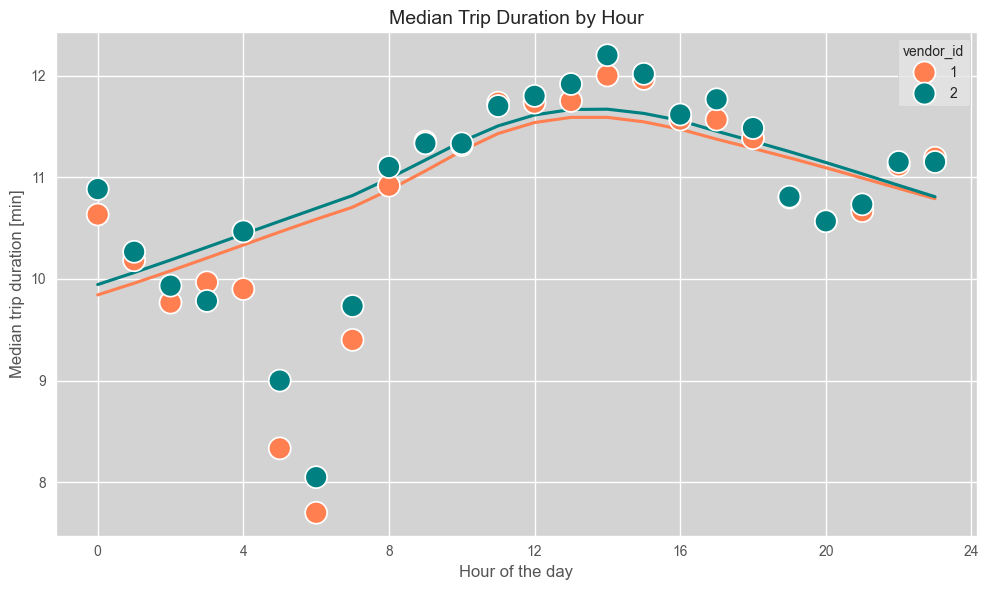

In [66]:
if 'pickup_hour' not in trainfull_copy.columns:
    trainfull_copy['pickup_hour'] = trainfull_copy['pickup_datetime'].dt.hour

# Calculate median duration per hour and vendor
summary_data = trainfull_copy.groupby(['pickup_hour', 'vendor_id'])['trip_duration_min'].median().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

colors = {1: 'coral', 2: 'teal'}

# Add SMOOTHING curves
for vendor in [1, 2]:
    subset = summary_data[summary_data['vendor_id'] == vendor]
    if not subset.empty:
        sns.regplot(
            data=subset,
            x='pickup_hour',
            y='trip_duration_min',
            scatter=False,
            lowess=True,
            color=colors[vendor],
            ax=ax
        )

# Add POINTS
sns.scatterplot(
    data=summary_data,
    x='pickup_hour',
    y='trip_duration_min',
    hue='vendor_id',
    palette=colors,
    s=250,
    ax=ax,
    zorder=3
)

# 3. Styling
ax.set_xlabel("Hour of the day", fontsize=12)
ax.set_ylabel("Median trip duration [min]", fontsize=12)
ax.set_title("Median Trip Duration by Hour", fontsize=14)
ax.set_xticks(range(0, 25, 4))  
ax.set_facecolor('lightgrey')
ax.grid(True, color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)

# Remove legend if desired
ax.get_legend()

plt.tight_layout()
plt.show()

#####There is a pattern for days of the week and hour of days. Seems that trip duration tend to be quicker towards quieter hours in the day and quiter days in the week. 

## Date/time vs passengers

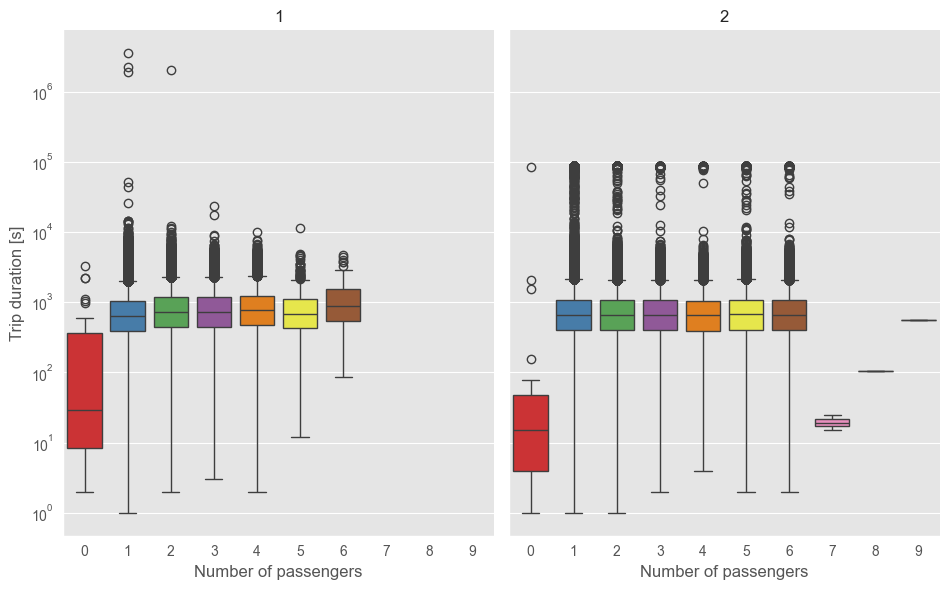

In [67]:
sns.set_style("whitegrid")
plt.style.use('ggplot')

# Create a FacetGrid for the two vendors
g = sns.FacetGrid(trainfull_copy, col='vendor_id', height=6, aspect=0.8)

# Map boxplot to each facet with different colors per passenger_count
g.map_dataframe(
    sns.boxplot,
    x='passenger_count',
    y='trip_duration',
    hue='passenger_count',
    palette='Set1', 
    legend=False
)

# Set log scale on y-axis
for ax in g.axes.flat:
    ax.set_yscale('log')

# Labels
g.set_axis_labels('Number of passengers', 'Trip duration [s]')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

#####Without any passengers both vendors have short trips. 
#####Vendor 1 has trip_durations beyond 24 hours which we will remove during cleaning. Vendor 2 has all (five) trips iwht more than 6 passengers and more trip durations that approach the 24 hour limit 

# **(3) Create new features**

In [68]:
# Calculate the shortest distance through 2 points
def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371  #Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return radius * c

def create_datetime_features(data):
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

    #Extract time features
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day'] = data['pickup_datetime'].dt.day
    data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
    data['pickup_month'] = data['pickup_datetime'].dt.month

    #Pretty cool thing here cuz you map the time and day to a circle so the model understands
    #That 12AM (hour 0) and 11PM (23) are not far apart for example
    data['pickup_hour_sin'] = np.sin(2 * np.pi * data['pickup_hour'] / 24)
    data['pickup_hour_cos'] = np.cos(2 * np.pi * data['pickup_hour'] / 24)
    data['pickup_dayofweek_sin'] = np.sin(2 * np.pi * data['pickup_dayofweek'] / 7)
    data['pickup_dayofweek_cos'] = np.cos(2 * np.pi * data['pickup_dayofweek'] / 7)

    return data

# separate function to help with cleaning (can't use on test set due us knowing the trip_duration)
def travel_speed(data):
    data['speed'] = data['haversine_distance'] / (data['trip_duration'] / 3600)
    return data


In [69]:
def create_geo_features(data):
    #Very rough estimation of how you would actually drive to the point
    #since we can't drive through buildings
    def street_distance(lat1, lon1, lat2, lon2):
        lat_dist = haversine_distance(lat1, lon1, lat2, lon1)
        lon_dist = haversine_distance(lat1, lon1, lat1, lon2)
        return lat_dist + lon_dist

    data['haversine_distance'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    data['street_distance'] = street_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])

    #Taxi speeds depend on how far they are from the city's "center"
    #I chose the East Village in Manhattan but thats an arbitrary choice
    nyc_center = (40.72680913695419, -73.98296948105471) #East Village 131 Ave A

    data['dropoff_distance_from_center'] = haversine_distance(data['dropoff_latitude'], data['dropoff_longitude'], nyc_center[0], nyc_center[1])
    data['pickup_distance_from_center'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'], nyc_center[0], nyc_center[1])

    return data

In [70]:
trainfull = create_datetime_features(trainfull)
trainfull = create_geo_features(trainfull)

# Also add features to trainfull_copy to preserve uncleaned data with features for visualizations
trainfull_copy = create_datetime_features(trainfull_copy)
trainfull_copy = create_geo_features(trainfull_copy)

#####Speed Distribution 

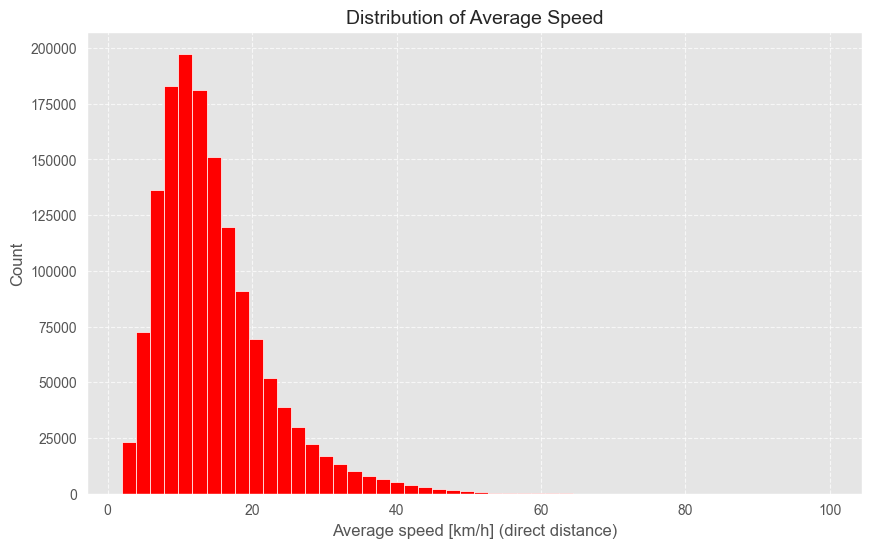

In [71]:
# Ensure speed is calculated (using your travel_speed function logic or existing column)
if 'speed' not in trainfull_copy.columns:
    trainfull_copy['speed'] = trainfull_copy['haversine_distance'] / (trainfull_copy['trip_duration'] / 3600)

# Filter the data: speed > 2 km/h and speed < 100 km/h
# Note: creating a copy to avoid SettingWithCopyWarning if we modify it later
filtered_speed = trainfull_copy[(trainfull_copy['speed'] > 2) & (trainfull_copy['speed'] < 100)].copy()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_speed['speed'], bins=50, color='red', edgecolor='white')

# Add labels and title
plt.xlabel('Average speed [km/h] (direct distance)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Average Speed', fontsize=14)

# Optional: Add grid for better readability, similar to default ggplot style
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

We are using a reasonable range of 2 km/h - 100 km/h for a typical NYC taxi drive. We find the average speed of 15 km/h is pretty reasonable for NYC. 

**NOTE:** Since we don't have the total path distance traveled, our taxis move directly to drop off coordinates (essentially flying). We refer to the minimum possible travel distance (haversine dist) which is the shortest path along the surface of a sphere between two points

We won't be using speed in our model since it requires us to know the trip_duration which would be cheating on our test dataset. Rather we will be using it to help clean our dataset

# **(4) Cleaning Data**

Here we are trying to remove outlier data points that may lead to a decrease in performance of our model. We provided some cases in which some features seem very unlikely for a NYC taxi trip

#### Day long trips

In [72]:
# Filter for trips longer than 24 hours (24 * 3600 seconds)
day_plus_trips = trainfull_copy[trainfull_copy['trip_duration'] > 24*3600]

# Calculate speed in km/h (Distance is in km, Duration is in seconds)
# Note: This relies on 'haversine_distance' being present from your create_geo_features function
day_plus_trips['speed'] = day_plus_trips['haversine_distance'] / (day_plus_trips['trip_duration'] / 3600)

# Select the specific columns to create the view
result = day_plus_trips[['pickup_datetime', 'dropoff_datetime', 'speed']]

# Display the result (pandas DataFrame is the equivalent of a tibble)
print(result)

           pickup_datetime     dropoff_datetime     speed
355003 2016-01-05 00:19:42  2016-01-27 11:08:38  0.037394
680594 2016-02-13 22:38:00  2016-03-08 15:57:38  0.010508
924150 2016-01-05 06:14:15  2016-01-31 01:01:07  0.002642
978383 2016-02-13 22:46:52  2016-03-25 18:18:14  0.020317


/var/folders/fg/jt9mq0js5cqgg812yfmz3gg00000gp/T/ipykernel_25813/1691116914.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



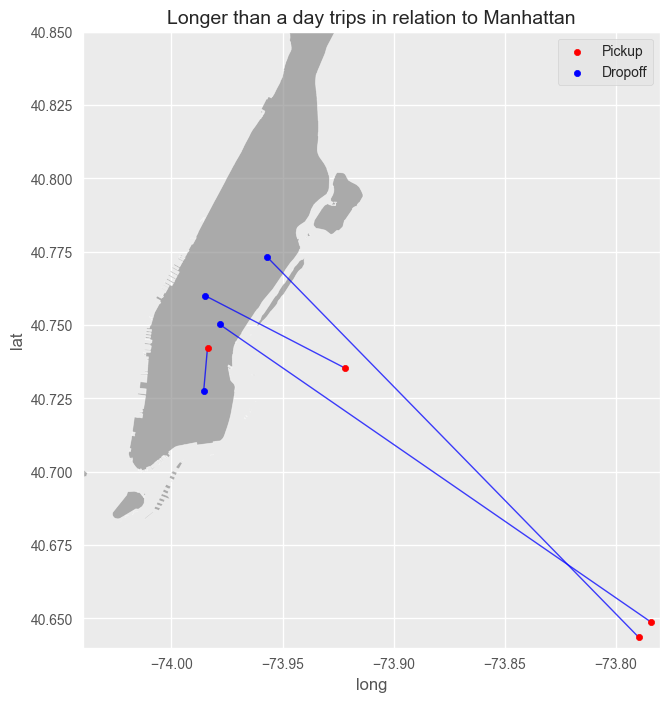

In [73]:
import matplotlib.patches as patches
from geodatasets import get_path
import geopandas as gpd


fig, ax = plt.subplots(figsize=(12, 8))

path_to_data = get_path('nybb')
gdf = gpd.read_file(path_to_data)

manhattan = gdf[gdf['BoroName'] == 'Manhattan'].to_crs("EPSG:4326")

# Draw lines connecting Pickup to Dropoff for each trip
# (Iterating is fine here since there are very few data points > 24hrs)
for _, row in day_plus_trips.iterrows():
    ax.plot([row['pickup_longitude'], row['dropoff_longitude']], 
            [row['pickup_latitude'], row['dropoff_latitude']], 
            color='blue', alpha=0.75, linewidth=1)

# Draw Manhattan Polygon
manhattan.plot(ax=ax, color='grey', alpha=0.6, edgecolor='white')

# Pickup (Red)
ax.scatter(day_plus_trips['pickup_longitude'], day_plus_trips['pickup_latitude'], 
           color='red', s=20, label='Pickup', zorder=5)

# Dropoff (Blue)
ax.scatter(day_plus_trips['dropoff_longitude'], day_plus_trips['dropoff_latitude'], 
           color='blue', s=20, label='Dropoff', zorder=5)


ax.set_title("Longer than a day trips in relation to Manhattan", fontsize=14)
ax.set_xlabel("long")
ax.set_ylabel("lat")
ax.set_facecolor('#EBEBEB')  # Light grey background
ax.grid(True, color='white', linewidth=1)  # White grid lines

# Set limits to focus on the Manhattan/NYC area 
# (Based on the coordinates seen in your R plot example)
ax.set_xlim(-74.04, -73.78)
ax.set_ylim(40.64, 40.85)

ax.legend()
plt.show()

Some of these trips from JFK airport are quite far, they are unlikely to than a day in reality.

#### Trips close to 24 hours 

In [74]:
# Filter for trips close to 24 hours (24 * 3600 seconds)
day_trips = trainfull_copy[(trainfull_copy['trip_duration'] > 22*3600) & (trainfull_copy['trip_duration'] < 24*3600*2)].copy()

day_trips['speed'] = day_trips['haversine_distance'] / (day_trips['trip_duration'] / 3600)  # 3600 seconds in an hour

# Select the specific columns to create the view
result = day_trips[['pickup_datetime', 'dropoff_datetime', 'speed']]

# Display the result (pandas DataFrame is the equivalent of a tibble)
print(result)

            pickup_datetime     dropoff_datetime     speed
531     2016-02-20 04:03:06  2016-02-21 03:33:00  0.127363
1134    2016-05-07 18:36:22  2016-05-08 18:32:11  0.049147
1865    2016-06-07 12:58:48  2016-06-08 12:58:00  0.182022
3442    2016-02-13 00:21:49  2016-02-14 00:19:05  0.077623
4172    2016-03-18 11:54:20  2016-03-19 11:34:17  0.090612
...                     ...                  ...       ...
1454858 2016-06-23 16:04:53  2016-06-24 16:01:33  0.191611
1456458 2016-02-08 19:11:31  2016-02-09 19:08:44  0.055870
1457207 2016-06-08 16:29:12  2016-06-09 16:11:03  0.030631
1457752 2016-02-02 11:31:10  2016-02-03 11:29:44  0.069796
1458076 2016-04-24 00:58:34  2016-04-25 00:56:16  0.031277

[1902 rows x 3 columns]


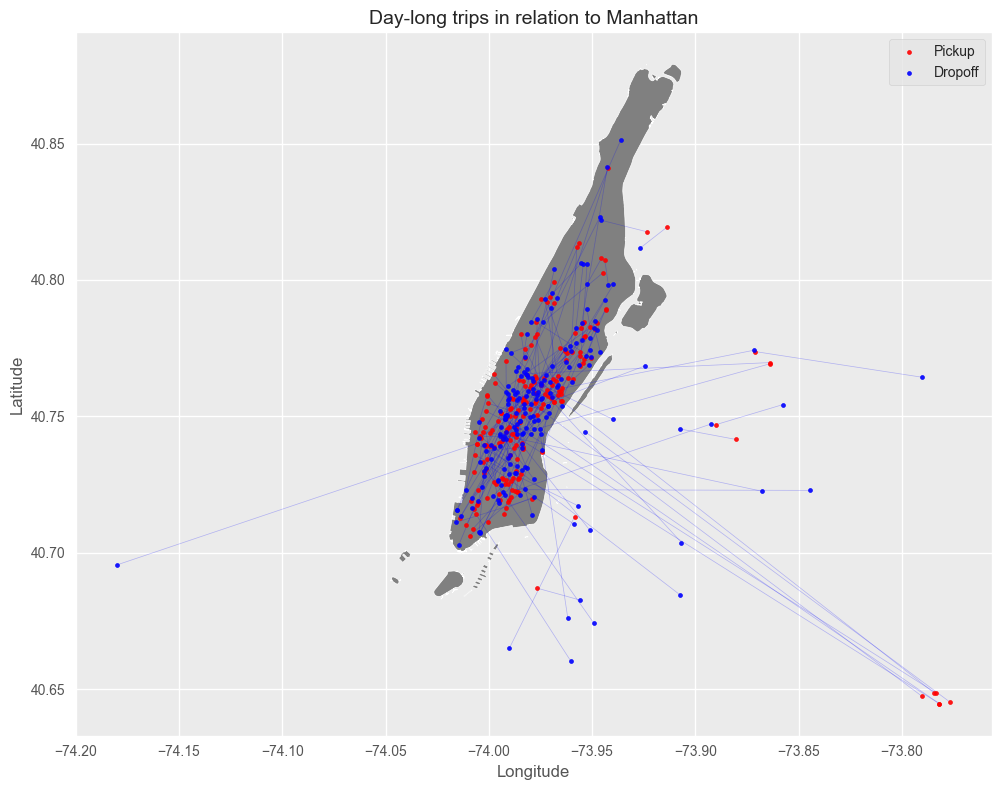

In [75]:
# 2) Sample 200 trips
np.random.seed(2017)
day_trips = day_trips.sample(n=min(200, len(day_trips)), random_state=2017).copy()

# 3) Pickup/dropoff coords
tpick = day_trips[["pickup_longitude", "pickup_latitude"]].rename(columns={"pickup_longitude": "lon", "pickup_latitude": "lat"})
tdrop = day_trips[["dropoff_longitude", "dropoff_latitude"]].rename(columns={"dropoff_longitude": "lon", "dropoff_latitude": "lat"})

# 4) Great-circle interpolation (equivalent to gcIntermediate)
def gc_intermediate(point1, point2, n=30, add_start_end=True):
    start = Point(point1[0], point1[1])
    end = Point(point2[0], point2[1])
    dist = geodesic(start, end)
    pts = []
    if add_start_end:
        pts.append((point1[1], point1[0]))  # (lon, lat)
    for i in range(1, n + 1):
        fraction = i / (n + 1)
        inter = dist.destination(start, dist.kilometers * fraction)
        pts.append((inter.longitude, inter.latitude))
    if add_start_end:
        pts.append((point2[1], point2[0]))
    return np.array(pts)

# 5) Manhattan polygon
path_to_data = get_path("nybb")
gdf = gpd.read_file(path_to_data)
manhattan = gdf[gdf["BoroName"] == "Manhattan"].to_crs("EPSG:4326")

# 6) Plot
fig, ax = plt.subplots(figsize=(12, 8))
manhattan.plot(ax=ax, color="grey", alpha=1, edgecolor="white")

# Points
ax.scatter(tpick["lon"], tpick["lat"], s=8, color="red", alpha=0.9, label="Pickup", zorder=5)
ax.scatter(tdrop["lon"], tdrop["lat"], s=8, color="blue", alpha=0.9, label="Dropoff", zorder=5)

# Direct (shortest) line between pickup and dropoff
for i in range(len(tpick)):
    ax.plot(
        [tpick.iloc[i]["lon"], tdrop.iloc[i]["lon"]],
        [tpick.iloc[i]["lat"], tdrop.iloc[i]["lat"]],
        color="blue",
        alpha=0.25,
        linewidth=0.5,
        zorder=3
)

ax.set_title("Day-long trips in relation to Manhattan", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_facecolor("#EBEBEB")
ax.grid(True, color="white", linewidth=1)
ax.set_axisbelow(True)
ax.legend()
plt.tight_layout()
plt.show()

We are only plotting 200 of the 1800 trips to make the map readable.

We find that there are a few longer distances that stand out such as trips going to JFK airport, but they can be exceptions due to the fact NYC is a big urban city with heavy traffic.

**Note:** We will leave out trip durations longer than 22 hours from the exploration of our model

#### Zero distance trips

In [76]:
# number of zero distance trips
zero_dist = trainfull_copy[np.isclose(trainfull_copy['haversine_distance'], 0)]

# Print the number of rows
print(len(zero_dist))

5897


#### Short trips with high avg speeds 

In [77]:
# Filter for short trips (< 5 minutes) with distance > 0
fast_trips = trainfull_copy[
    (trainfull_copy['trip_duration'] < 5*60) & 
    (trainfull_copy['haversine_distance'] > 0)
].copy()

# Calculate speed in km/h
fast_trips['speed'] = fast_trips['haversine_distance'] / (fast_trips['trip_duration'] / 3600)

# Sort by speed descending and select columns
result = (
    fast_trips
    .sort_values('speed', ascending=False)
    [['trip_duration', 'haversine_distance', 'pickup_datetime', 'speed']]
    .head(10)
)

print(result)

         trip_duration  haversine_distance     pickup_datetime        speed
1176337              7           18.034405 2016-02-13 20:28:30  9274.836731
377068             282          320.125775 2016-04-02 20:33:19  4086.712020
1001028              2            0.783347 2016-06-12 06:35:13  1410.024743
906281              51           19.948152 2016-06-19 20:18:35  1408.104838
595540             279          104.759971 2016-03-20 21:07:56  1351.741558
1107                 2            0.703065 2016-06-23 13:36:48  1265.516683
898154              20            6.911542 2016-05-28 15:14:19  1244.077521
777670               3            0.912885 2016-05-30 17:12:12  1095.462175
1322903              4            1.029739 2016-01-17 03:11:56   926.765395
1200843              3            0.760976 2016-06-13 16:34:30   913.171260


The top speeds in km/h are unrealistic. So we can filter them from this dataset

#### Coordinates far from JFK wtih zero trip distance

In [78]:
# Define JFK coordinates (approximate)
jfk_center = (40.6413, -73.7781)

# Calculate distances to JFK for all rows
trainfull_copy['jfk_dist_pick'] = haversine_distance(trainfull_copy['pickup_latitude'], trainfull_copy['pickup_longitude'], jfk_center[0], jfk_center[1])
trainfull_copy['jfk_dist_drop'] = haversine_distance(trainfull_copy['dropoff_latitude'], trainfull_copy['dropoff_longitude'], jfk_center[0], jfk_center[1])

# Filter: using 300 km as equivalent to 300,000 meters
long_dist = trainfull_copy[(trainfull_copy['jfk_dist_pick'] > 300) | (trainfull_copy['jfk_dist_drop'] > 300)].copy()

# Select coordinates (long_dist_coord)
long_dist_coord = long_dist[['pickup_longitude', 'pickup_latitude']].rename(columns={'pickup_longitude': 'lon', 'pickup_latitude': 'lat'})

# Calculate speed (if not already present in the subset)
long_dist['speed'] = long_dist['haversine_distance'] / (long_dist['trip_duration'] / 3600)

# Select specific columns and arrange by jfk_dist_pick descending
cols_to_show = ['id', 'jfk_dist_pick', 'jfk_dist_drop', 'haversine_distance', 'trip_duration', 'speed']

# Note: mapped 'dist' to 'haversine_distance'
print(long_dist[cols_to_show].sort_values('jfk_dist_pick', ascending=False))

                id  jfk_dist_pick  jfk_dist_drop  haversine_distance  \
1184454  id2854272    4124.138513    4124.130330            0.014810   
1068810  id3777240    4124.132919    4124.137929            0.021800   
184925   id2306955    1251.992048      21.413774         1240.908677   
804402   id1974018    1114.369251    1114.369251            0.000000   
782256   id0267429     987.710856     987.710856            0.000000   
1060807  id0838705     694.826023     480.443462          215.226573   
1387351  id0205460     683.327230     683.327230            0.000000   
275644   id0978162     673.682219     940.740447          314.764203   
962552   id3525158     665.215979     665.215979            0.000000   
974378   id1510552     642.093908     471.561235          891.214103   
775976   id1125911     611.263574     627.154042           15.921468   
952661   id0784573     604.050976     604.050976            0.000000   
1359910  id3628988     496.335663     571.877009           85.88

In [79]:
from ipyleaflet import Map, Marker, TileLayer, basemaps
from ipywidgets import HTML

# Create the map centered at the coordinates specified in the R code
m = Map(center=(41.0, -92.00), zoom=4, scroll_wheel_zoom=True)

# Add CartoDB Positron basemap (equivalent to addProviderTiles("CartoDB.Positron"))
m.add(basemaps.CartoDB.Positron)

# Add markers for each long distance trip
for idx, row in long_dist.iterrows():
    marker = Marker(location=(row['pickup_latitude'], row['pickup_longitude']), draggable=False)
    
    # Popup content (distance)
    message = HTML()
    message.value = f"Distance: {row['haversine_distance']:.2f} km"
    marker.popup = message
    
    # Tooltip/Label (ID)
    marker.title = str(row['id'])
    
    m.add(marker)

# Display the map
m

Map(center=[41.0, -92.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Not too sure why our dataset has pickup coordinates that are in San Francisco or let alone in the ocean. So we will be removing them before training

## Final Cleaning

In [80]:
# Ensure JFK distances are calculated (if not already present from previous cells)
jfk_center = (40.6413, -73.7781)
if 'jfk_dist_pick' not in trainfull.columns:
    trainfull['jfk_dist_pick'] = haversine_distance(trainfull['pickup_latitude'], trainfull['pickup_longitude'], jfk_center[0], jfk_center[1])
    trainfull['jfk_dist_drop'] = haversine_distance(trainfull['dropoff_latitude'], trainfull['dropoff_longitude'], jfk_center[0], jfk_center[1])

# 2. Calculate speed in km/h for filtering
trainfull['speed'] = trainfull['haversine_distance'] / (trainfull['trip_duration'] / 3600)

# 3. Create the filter mask based on your R code criteria
# Note: 3e5 meters = 300 km. Our haversine_distance is in km.
filter_mask = (
    (trainfull['trip_duration'] < 22 * 3600) &          # trip_duration < 22*3600
    (trainfull['trip_duration'] > 10) &                 # trip_duration > 10
    (                                                   # dist > 0 | (near(dist, 0) & trip_duration < 60)
        (trainfull['haversine_distance'] > 0) | 
        (np.isclose(trainfull['haversine_distance'], 0) & (trainfull['trip_duration'] < 60))
    ) &
    (trainfull['jfk_dist_pick'] < 300) &                # jfk_dist_pick < 3e5 (300km)
    (trainfull['jfk_dist_drop'] < 300) &                # jfk_dist_drop < 3e5 (300km)
    (trainfull['speed'] < 100)                          # speed < 100 km/h (62 mph)
)

# 4. Apply the filter
print(f"Rows before filtering: {len(trainfull)}")
trainfull = trainfull[filter_mask].copy()
print(f"Rows after filtering: {len(trainfull)}")

Rows before filtering: 1458644
Rows after filtering: 1450263


# **(5) External Data**

As we interpreted from the project.pdf we wanted to try out exploring different datasets.

One particular area we wanted to observe is the effect of weather data on our trip_duration prediction feature. This weather data is collected from the National Weather Service and contains the weather of NYC for 2016.

It contains for each day the minimum temperature, maximum temperature, average temperature, precipitation, new snow fall, and current snow depth. The temperature is measured in Fahrenheit and the depth is measured in inches. 

##**NOTE:**
###train.csv from the taxi dataset only contains data up till July 2016

In [81]:
weather_data = pd.read_csv('../data/weather_data_nyc_centralpark_2016(1).csv')

weather_data['date'] = pd.to_datetime(weather_data['date'], format='%d-%m-%Y')

# CLEANING
def clean_trace(val):
    if val == 'T':
        return 0.01
    return float(val)

# We use .apply(clean_trace) to handle the logic: ifelse(col == "T", "0.01", col)
weather_data['rain'] = weather_data['precipitation'].apply(clean_trace)
weather_data['s_fall'] = weather_data['snow fall'].apply(clean_trace)
weather_data['s_depth'] = weather_data['snow depth'].apply(clean_trace)

# Create derived columns
weather_data['all_precip'] = weather_data['s_fall'] + weather_data['rain']

weather_data['has_snow'] = (weather_data['s_fall'] > 0) | (weather_data['s_depth'] > 0)
weather_data['has_rain'] = weather_data['rain'] > 0

# Renaming 
weather_data['max_temp'] = weather_data['maximum temperature']
weather_data['min_temp'] = weather_data['minimum temperature']



In [82]:
# List of original columns to drop
cols_to_drop = [
    'precipitation', 
    'snow fall', 
    'snow depth', 
    'maximum temperature', 
    'minimum temperature',
    'average temperature'
]

# Drop them in place
weather_data.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Check the remaining columns
print(weather_data.columns.tolist())

['date', 'rain', 's_fall', 's_depth', 'all_precip', 'has_snow', 'has_rain', 'max_temp', 'min_temp']


In [83]:
# Create trainfull_copy with uncleaned data for visualizations
weather_data_copy = weather_data.copy()
# Display info to verify the dataframe loaded correctly
print(f"weather_data_copy shape: {weather_data_copy.shape}")
print(f"\nFirst few rows:")
weather_data_copy.head()

weather_data_copy shape: (366, 9)

First few rows:


,date,rain,s_fall,s_depth,all_precip,has_snow,has_rain,max_temp,min_temp
0,2016-01-01,0.0,0.0,0.0,0.0,False,False,42,34
1,2016-01-02,0.0,0.0,0.0,0.0,False,False,40,32
2,2016-01-03,0.0,0.0,0.0,0.0,False,False,45,35
3,2016-01-04,0.0,0.0,0.0,0.0,False,False,36,14
4,2016-01-05,0.0,0.0,0.0,0.0,False,False,29,11


## Left join the training dataset on "date"

In [84]:
# Identify columns you want to remove from trainfull (if they exist)
# This includes both the new names and any potential original names and unnecesary columns
cols_to_remove = [
    'rain', 's_fall', 's_depth', 'all_precip', 'has_snow', 'has_rain', 'max_temp', 'min_temp',
    'precipitation', 'snow fall', 'snow depth', 'maximum temperature', 'minimum temperature'
]


trainfull.drop(columns=cols_to_remove, inplace=True, errors='ignore')

# Drop any columns ending in _x or _y (artifacts from previous bad merges)
cols_to_drop = [c for c in trainfull.columns if c.endswith('_x') or c.endswith('_y')]
trainfull.drop(columns=cols_to_drop, inplace=True)

trainfull['date'] = pd.to_datetime(trainfull['pickup_datetime']).dt.normalize()
# Perform the merge with your cleaned weather_data
trainfull = trainfull.merge(weather_data, on='date', how='left')

print(f"Shape: {trainfull.shape}")
print('\n'.join(map(str, trainfull.columns)))
trainfull.head()


Shape: (1450263, 35)
id
vendor_id
pickup_datetime
dropoff_datetime
passenger_count
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
store_and_fwd_flag
trip_duration
pickup_hour
pickup_day
pickup_dayofweek
pickup_month
pickup_hour_sin
pickup_hour_cos
pickup_dayofweek_sin
pickup_dayofweek_cos
haversine_distance
street_distance
dropoff_distance_from_center
pickup_distance_from_center
jfk_dist_pick
jfk_dist_drop
speed
date
rain
s_fall
s_depth
all_precip
has_snow
has_rain
max_temp
min_temp


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,speed,date,rain,s_fall,s_depth,all_precip,has_snow,has_rain,max_temp,min_temp
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,11.856428,2016-03-14,0.29,0.0,0.00,0.29,False,True,51,40
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,9.803659,2016-06-12,0.00,0.0,0.00,0.00,False,False,83,62
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,10.822201,2016-01-19,0.00,0.0,0.01,0.00,True,False,28,16
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,12.465721,2016-04-06,0.00,0.0,0.00,0.00,False,False,48,30
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,9.836594,2016-03-26,0.00,0.0,0.00,0.00,False,False,55,38


## Visualizing snow fall numbers per day

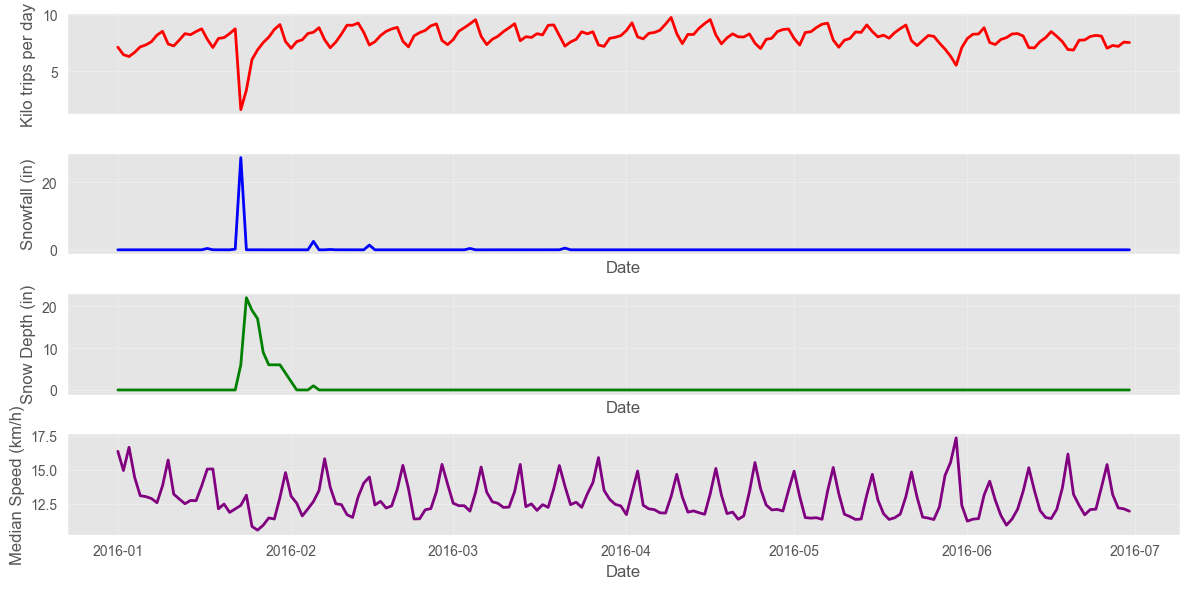

In [85]:
# Aggregate data by date
# Count trips per day and get the max snowfall for that day (snowfall is constant per day)
daily_stats = trainfull.groupby('date').agg({
    'id': 'count',          # Count number of trips
    's_fall': 'mean',      # Get snowfall for the day
    's_depth': 'mean',      # Get snow depth for the day
    'speed': 'median' # Get median speed for the day
}).reset_index()

# Rename columns for clarity
daily_stats.columns = ['date', 'trip_count', 's_fall', 's_depth', 'median_speed']

# Create the plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

# Kilo trips per day (Red line)
ax1.plot(daily_stats['date'], daily_stats['trip_count'] / 1000, 
         color='red', linewidth=2)
ax1.set_ylabel('Kilo trips per day', fontsize=12)
ax1.grid(True, alpha=0.3)

# Snowfall (Blue line)
ax2.plot(daily_stats['date'], daily_stats['s_fall'], 
         color='blue', linewidth=2)
ax2.set_ylabel('Snowfall (in)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

# Snow Depth (Green line)
ax3.plot(daily_stats['date'], daily_stats['s_depth'], 
         color='green', linewidth=2)
ax3.set_ylabel('Snow Depth (in)', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.grid(True, alpha=0.3)

ax4.plot(daily_stats['date'], daily_stats['median_speed'], 
         color='purple', linewidth=2)
ax4.set_ylabel('Median Speed (km/h)', fontsize=12)
ax4.set_xlabel('Date', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

A notable distinction in the data shows that there was heavy snow fall in the winter of Jan 2016 in NYC. Which ended up being the largest blizzard in the city's history. 

This explains the impact of trips per day, an increase in snow fall and especially snow depth showed a decrease in median speeds notably. 

## Comparing Total precipitation to average trip duration

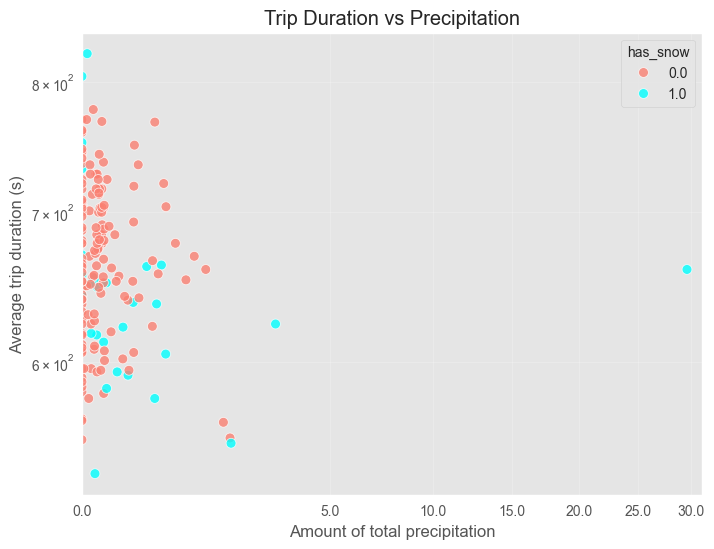

In [90]:

import matplotlib.ticker as ticker
summary = (trainfull
           .groupby('date')[['all_precip', 'trip_duration', 'has_snow']]
           .median()
           .reset_index()
           .rename(columns={'trip_duration': 'duration'}))

# Ensure columns are float
summary['all_precip'] = summary['all_precip'].astype(float)
summary['duration'] = summary['duration'].astype(float)

fig, ax = plt.subplots(figsize=(8, 6))

jitter_strength = 0.04
noise = np.random.uniform(-jitter_strength, jitter_strength, size=len(summary))
jittered_x = summary['all_precip'] + noise

# Clip to ensure no negatives, but allow 0
jittered_x = jittered_x.clip(lower=0.0)

sns.scatterplot(
    data=summary,
    x=jittered_x,
    y='duration',
    hue='has_snow',
    palette={True: 'cyan', False: 'salmon'},
    s=50,
    ax=ax,
    alpha=0.8
)

ax.set_xscale('function', functions=(np.sqrt, np.square))
# Force limit to start at 0 
ax.set_xlim(left=0)

ax.set_yscale('log')

# Format ticks nicely
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter()) # Keeps numbers readable (1000 instead of 1e3)


ax.set_xlabel("Amount of total precipitation")
ax.set_ylabel("Average trip duration (s)")
ax.set_title("Trip Duration vs Precipitation")
ax.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

The one exception of the snow day with long trip duration trips would incline that more snow would lead to shorter snow trips. However, it is a possibility that passengers were more likely to travel shorter distances

# **(6)Correlations**



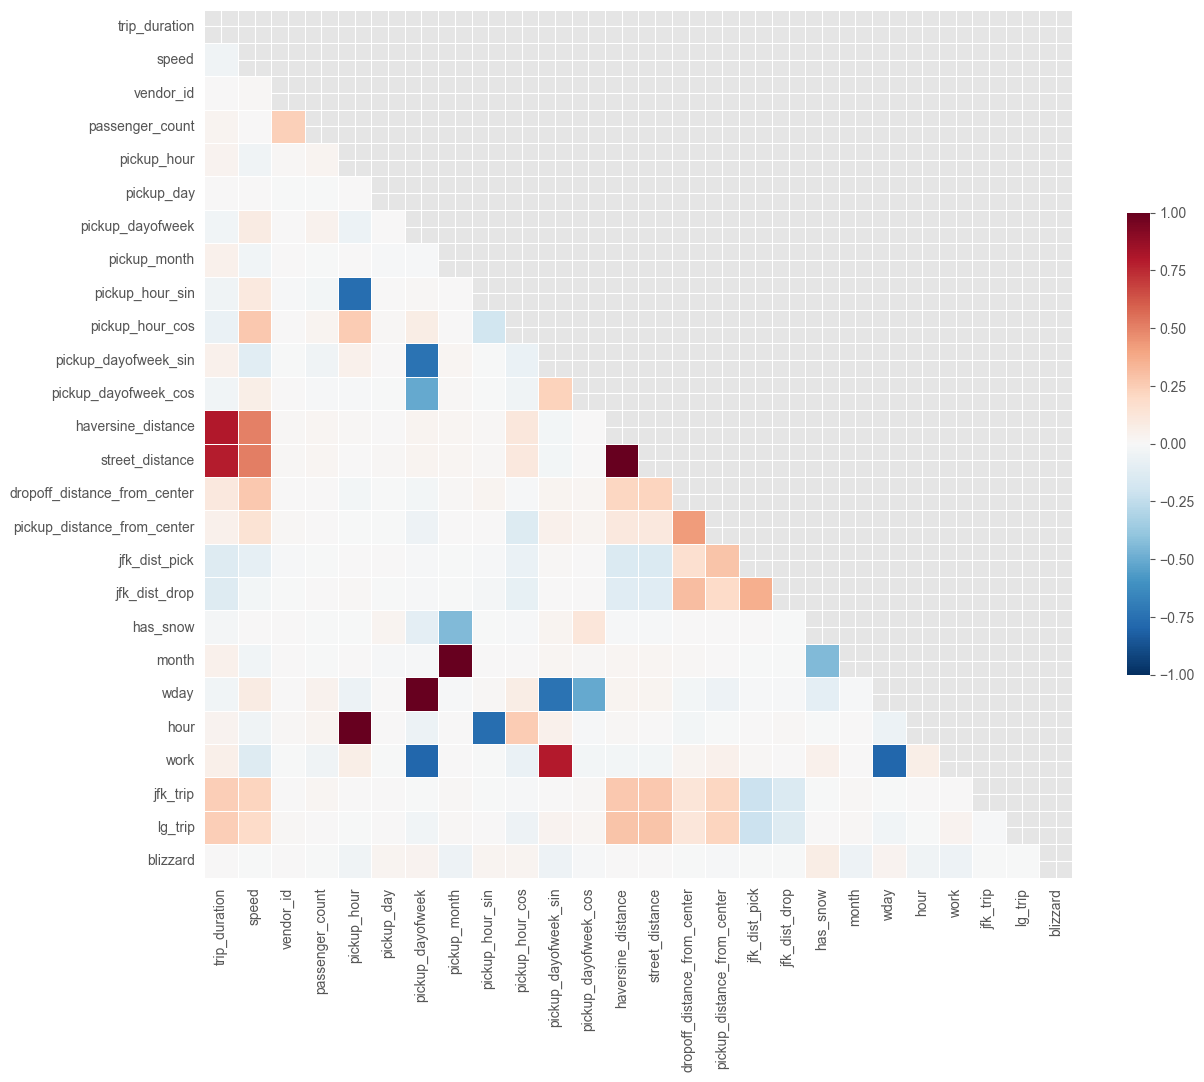

In [87]:
# 1. Efficiently sample the data (Spearman corr on 1.4M rows is very slow)
#    100k rows is statistically sufficient for stable correlation coefficients.
df_viz = trainfull.sample(n=100000, random_state=42).copy()

# 2. Re-create Time & Date features (dropped in previous steps)
df_viz['pickup_datetime'] = pd.to_datetime(df_viz['pickup_datetime'])
df_viz['month'] = df_viz['pickup_datetime'].dt.month
df_viz['wday'] = df_viz['pickup_datetime'].dt.dayofweek
df_viz['hour'] = df_viz['pickup_datetime'].dt.hour
df_viz['work'] = (df_viz['wday'] < 5).astype(int) # Approx: Mon-Fri

# 3. Re-create Location Flags (Approximate JFK/LGA trips)
#    We define a 'trip' as starting OR ending within 2km of the airport
jfk_center = (40.6413, -73.7781)
lga_center = (40.7769, -73.8740)

def is_near(lat, lon, center, threshold_km=2):
    # Simplified Haversine for vectorization
    R = 6371
    phi1, phi2 = np.radians(lat), np.radians(center[0])
    dphi = np.radians(center[0] - lat)
    dlambda = np.radians(center[1] - lon)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return (2 * R * np.arctan2(np.sqrt(a), np.sqrt(1-a))) < threshold_km

# Vectorized creation of location flags
jfk_pick = is_near(df_viz['pickup_latitude'], df_viz['pickup_longitude'], jfk_center)
jfk_drop = is_near(df_viz['dropoff_latitude'], df_viz['dropoff_longitude'], jfk_center)
lga_pick = is_near(df_viz['pickup_latitude'], df_viz['pickup_longitude'], lga_center)
lga_drop = is_near(df_viz['dropoff_latitude'], df_viz['dropoff_longitude'], lga_center)

df_viz['jfk_trip'] = (jfk_pick | jfk_drop).astype(int)
df_viz['lg_trip'] = (lga_pick | lga_drop).astype(int)

# 4. Handle Booleans/Categoricals
df_viz['store_and_fwd_flag'] = (df_viz['store_and_fwd_flag'] == 'Y').astype(int)
df_viz['has_snow'] = df_viz['has_snow'].astype(int)
df_viz['has_rain'] = df_viz['has_rain'].astype(int)
# Arbitrary 'blizzard' definition if not in data: > 5 inches snow
df_viz['blizzard'] = (df_viz['s_fall'] > 5).astype(int) 

# 5. Filter and Order Columns (Put trip_duration & speed first)
#    Drop raw coordinates/dates/ids as they don't have meaningful linear correlation
cols_to_drop = ['id', 'pickup_datetime', 'dropoff_datetime', 'date', 
                'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'max_temp', 'min_temp', 'average_temperature', 'has_rain', 'store_and_fwd_flag',
                's_fall', 's_depth', 'all_precip', 'rain']
df_viz = df_viz.drop(columns=[c for c in cols_to_drop if c in df_viz.columns], errors='ignore')

# Sort columns to put trip_duration and speed at the top
first_cols = ['trip_duration', 'speed']
other_cols = [c for c in df_viz.columns if c not in first_cols]
# Select only numeric columns for correlation
df_viz = df_viz[first_cols + other_cols].select_dtypes(include=[np.number])

# 6. Compute Spearman Correlation (Monotonic relationships)
corr_matrix = df_viz.corr(method='spearman')

# 7. Plot
plt.figure(figsize=(14, 12))

# Mask the upper triangle (diag=False in R code)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


sns.heatmap(
    corr_matrix, 
    mask=mask, 
    cmap='RdBu_r',     
    center=0, 
    vmax=1, 
    vmin=-1,
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": .5}
)

plt.show()

# **(7) Hyperparameter tuning: Train models with different values**

In [93]:
#Select features for the model
feature_columns = [
    # Geographic features
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'haversine_distance', 'street_distance',
    'pickup_distance_from_center', 'dropoff_distance_from_center',
    
    # Time features
    'pickup_hour_sin', 'pickup_hour_cos',
    'pickup_dayofweek_sin', 'pickup_dayofweek_cos',
    'pickup_day', 'pickup_month',
]

X = trainfull[feature_columns]
y = trainfull['trip_duration']

# removing rows with NaN values
mask = ~np.isnan(y)
X_clean = X[mask]
Y_clean = y[mask]

Y_clean = np.log1p(y[mask]) 

In [94]:
#Split data
X_train, X_val, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.1, random_state=39)

print(f"Target stats - Min: {y_test.min()}, Max: {y_test.max()}, Mean: {y_test.mean()}, Std: {y_test.std()}")
print(f"Training shape: {X_train.shape}")
print(f"Target variance: {y_test.var()}")

Target stats - Min: 2.4849066497880004, Max: 11.250859156109557, Mean: 6.472103868745829, Std: 0.7540193084168305
Training shape: (1305236, 14)
Target variance: 0.5685451174653954


In [95]:
hyperparams = {
    'learning_rate': [0.01, 0.05],
    'max_iter': [500, 1000],
    'max_depth': [5, 7, None],
    'min_samples_leaf': [10, 20],
    'l2_regularization': [0.1, 1, 10],
    'max_leaf_nodes': [63, 127],
    'max_bins': [255],
}

base_model = HistGradientBoostingRegressor(
    random_state=39,
    early_stopping=True,
    validation_fraction=0.2,
    scoring='loss'
)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=hyperparams,
    n_iter=5,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=39,
    verbose=2
)

#fit the random search
print("Currently tuning hyperparameters. Sit tight...")
random_search.fit(X_train, y_train)

Currently tuning hyperparameters. Sit tight...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END l2_regularization=10, learning_rate=0.05, max_bins=255, max_depth=5, max_iter=1000, max_leaf_nodes=63, min_samples_leaf=10; total time= 2.5min
[CV] END l2_regularization=10, learning_rate=0.05, max_bins=255, max_depth=5, max_iter=1000, max_leaf_nodes=63, min_samples_leaf=10; total time= 2.5min
[CV] END l2_regularization=10, learning_rate=0.05, max_bins=255, max_depth=5, max_iter=1000, max_leaf_nodes=63, min_samples_leaf=10; total time= 2.6min
[CV] END l2_regularization=0.1, learning_rate=0.01, max_bins=255, max_depth=5, max_iter=1000, max_leaf_nodes=127, min_samples_leaf=10; total time= 2.8min
[CV] END l2_regularization=0.1, learning_rate=0.01, max_bins=255, max_depth=5, max_iter=1000, max_leaf_nodes=127, min_samples_leaf=10; total time= 2.8min
[CV] END l2_regularization=0.1, learning_rate=0.01, max_bins=255, max_depth=5, max_iter=1000, max_leaf_nodes=127, min_samples_lea

,estimator,HistGradientB..._fraction=0.2)
,param_distributions,"{'l2_regularization': [0.1, 1, ...], 'learning_rate': [0.01, 0.05], 'max_bins': [255], 'max_depth': [5, 7, ...], ...}"
,n_iter,5
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,39
,error_score,nan


**Stats**

In [97]:
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Score: {random_search.best_score_}")

#Get the best model
best_model = random_search.best_estimator_

y_val_pred_log = best_model.predict(X_val)

# Convert Predictions to Seconds
y_val_pred_seconds = np.expm1(y_val_pred_log)

# If y_test comes from the transformed Y_clean, it is currently in LOG units.
# So we must convert it back
y_test_seconds = np.expm1(y_test) 

# 4. Calculate RMSE in Seconds
val_rmse = np.sqrt(mean_squared_error(y_test_seconds, y_val_pred_seconds))
print(f"Validation RMSE (in seconds): {val_rmse}")

val_rmse = np.sqrt(mean_squared_error(y_test, y_val_pred_seconds))
print(f"Validation RMSE: {val_rmse}")

Best Parameters: {'min_samples_leaf': 10, 'max_leaf_nodes': 127, 'max_iter': 1000, 'max_depth': None, 'max_bins': 255, 'learning_rate': 0.01, 'l2_regularization': 0.1}
Best Cross-Validation Score: -0.34576125969656474
Validation RMSE (in seconds): 614.7351284637525
Validation RMSE: 974.0017885126153


In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on the validation set
# Use the trained model (best_model from RandomizedSearchCV)
result = permutation_importance(
    best_model, 
    X_val, 
    y_test,  # these are your validation targets
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Extract and sort importance values
imp_values = result.importances_mean
sorted_idx = np.argsort(imp_values)[::-1]  # descending order

# Plot
plt.figure(figsize=(12, 6))
plt.bar([feature_columns[i] for i in sorted_idx], imp_values[sorted_idx], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Permutation Importance")
plt.xlabel("Feature")
plt.title("Feature Importance for Trip Duration Prediction")
plt.tight_layout()
plt.show()